In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.Citeseer import Citeseer
import dgl.function as fn
import torch
import numpy as np

torch.cuda.empty_cache()


/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Citeseer() 
original_graph = dataset.load_graph()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
original_graph = original_graph.to(device=device)
print(device)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
cuda


In [3]:
# 2. Utility: create train/val/test indices and corresponding labels

def get_splits_and_labels(hetero_graph, ntype='paper',train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, random_state=5):
    """
    Extract train/val/test node indices and their labels for a given node type.

    Returns
    # -------
    dict
        {
          'train_idx': LongTensor,
          'val_idx': LongTensor,
          'test_idx': LongTensor,
          'train_labels': LongTensor,
          'val_labels': LongTensor,
          'test_labels': LongTensor
        }
    """
    np.random.seed(random_state)
    indices = np.random.permutation(hetero_graph.nodes[ntype].data["feat"].size()[0])
    num_papers =hetero_graph.nodes[ntype].data["feat"].size()[0]
    
    train_size = int(num_papers * train_ratio)
    val_size = int(num_papers * val_ratio)
    
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_papers, dtype=torch.bool, device=device)
    val_mask = torch.zeros(num_papers, dtype=torch.bool, device=device)
    test_mask = torch.zeros(num_papers, dtype=torch.bool, device=device)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Add masks to hetero_data
    hetero_graph.nodes[ntype].data["train_mask"] = train_mask
    hetero_graph.nodes[ntype].data["val_mask"] = val_mask
    hetero_graph.nodes[ntype].data["test_mask"] = test_mask
    
    labels = hetero_graph.nodes[ntype].data['label']
    train_mask = hetero_graph.nodes[ntype].data['train_mask']
    val_mask = hetero_graph.nodes[ntype].data['val_mask']
    test_mask = hetero_graph.nodes[ntype].data['test_mask']

    train_idx = train_mask.nonzero(as_tuple=True)[0]
    val_idx = val_mask.nonzero(as_tuple=True)[0]
    test_idx = test_mask.nonzero(as_tuple=True)[0]

    return {
        'train_idx': train_idx,
        'val_idx': val_idx,
        'test_idx': test_idx,
        'train_labels': labels[train_idx],
        'val_labels': labels[val_idx],
        'test_labels': labels[test_idx]
    }

# Example usage:
#data_splits_orig = get_splits_and_labels(original_graph)

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(original_graph, coarsend_graph, mapping, get_splits_and_labels, model_class, num_runs=5, epochs=150):
    target_node_type = "paper"
    
    original_accuracies = []
    coarsened_accuracies = []
    inverted_accuracies = []
    

    for run in range(num_runs):
        #print(f"\n========== Run {run+1} ==========\n")

        # Get new splits
        splits_orig = get_splits_and_labels(original_graph, random_state=run)
        splits_coar = get_splits_and_labels(coarsend_graph, random_state=run)
        # train_idx_orig = torch.nonzero(original_graph.nodes["paper"].data["train_mask"]).squeeze()
        # test_idx_orig = torch.nonzero(original_graph.nodes["paper"].data["test_mask"]).squeeze()
        # val_idx_orig = torch.nonzero(original_graph.nodes["paper"].data["val_mask"]).squeeze()
        
        labels_orig = original_graph.nodes[target_node_type].data['label']
        
        # train_idx_coar =torch.nonzero(coarsend_graph.nodes["paper"].data["train_mask"]).squeeze()
        # test_idx_coar =torch.nonzero(coarsend_graph.nodes["paper"].data["test_mask"]).squeeze() 
        # val_idx_coar = torch.nonzero(coarsend_graph.nodes["paper"].data["val_mask"]).squeeze()
        labels_coar = coarsend_graph.nodes[target_node_type].data['label']
        
        train_idx_orig = splits_orig['train_idx']
        val_idx_orig = splits_orig['val_idx']
        test_idx_orig = splits_orig['test_idx']
        # labels_orig = original_graph.nodes[target_node_type].data['label']

        train_idx_coar = splits_coar['train_idx']
        val_idx_coar = splits_coar['val_idx']
        test_idx_coar = splits_coar['test_idx']
        
        
        feat_orig = {target_node_type: original_graph.nodes[target_node_type].data['feat']}
        feat_coar = {target_node_type: coarsend_graph.nodes[target_node_type].data['feat']}

        model_original = model_class(in_dim=feat_orig[target_node_type].shape[1], hidden_dim=256,
                                     out_dim=6, rel_names=original_graph.etypes)
        optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)

        model_coarsened = model_original.to(device=device)
        
        model_coarsened = model_class(in_dim=feat_coar[target_node_type].shape[1], hidden_dim=256,
                                      out_dim=6, rel_names=original_graph.etypes)
        model_coarsened = model_coarsened.to(device=device)
        optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)

        def train(model, graph, feats, labels, train_idx, optimizer):
            model.train()
            optimizer.zero_grad()
            logits = model(graph, feats)[target_node_type]
            loss = F.cross_entropy(logits[train_idx], labels[train_idx])
            loss.backward()
            optimizer.step()
            return loss.item()

        def test(model, graph, feats, labels, val_idx):
            model.eval()
            with torch.no_grad():
                logits = model(graph, feats)[target_node_type]
                preds = logits.argmax(dim=1)
                correct = (preds[val_idx] == labels[val_idx]).sum().item()
                return correct / val_idx.shape[0], preds

        def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
            correct_count = 0
            total_count = 0
            for orig_node, coarsened_node in inversion_map.items():
                if coarsened_node not in test_mask:
                    continue
                coarse_pred = coarsened_pred[coarsened_node]
                orig_label = original_labels[orig_node]
                if coarse_pred == orig_label:
                    correct_count += 1
                total_count += 1
            return correct_count / total_count if total_count > 0 else 0

        for epoch in range(epochs):
            train(model_original, original_graph, feat_orig, labels_orig, train_idx_orig, optimizer_original)
            train(model_coarsened, coarsend_graph, feat_coar, labels_coar, train_idx_coar, optimizer_coarsened)

        # Final test
        original_acc, _ = test(model_original, original_graph, feat_orig, labels_orig, val_idx_orig)
        coarsened_acc, preds = test(model_coarsened, original_graph, feat_orig, labels_orig, val_idx_orig)
        _, preds = test(model_original, coarsend_graph, feat_coar, labels_coar, val_idx_coar)
        
        inverted_acc = apply_inversion_mapping(preds, mapping, labels_orig, test_idx_coar)

        print(f"Original Graph Accuracy:   {original_acc:.4f}")
        print(f"Coarsened Graph Accuracy:  {coarsened_acc:.4f}")
        print(f"Inverted Coarsened Accuracy: {inverted_acc:.4f}")

        original_accuracies.append(original_acc)
        coarsened_accuracies.append(coarsened_acc)
        inverted_accuracies.append(inverted_acc)

    # Compute stats
    def summarize(name, values):
        values = np.array(values)
        print(f"\n{name}:")
        print(f"  Mean: {values.mean():.4f}")
        print(f"  Std:  {values.std():.4f}")
        return values

    orig_vals = summarize("Original Graph Accuracy", original_accuracies)
    coar_vals = summarize("Coarsened Graph Accuracy", coarsened_accuracies)
    inv_vals = summarize("Inverted Accuracy", inverted_accuracies)

    # Plot bar chart
    labels = [f"Run {i+1}" for i in range(num_runs)]
    x = np.arange(num_runs)
    width = 0.25

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, orig_vals, width, label='Original')
    plt.bar(x, coar_vals, width, label='Coarsened')
    plt.bar(x + width, inv_vals, width, label='Inverted')
    plt.xlabel('Run')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Across Multiple Runs')
    plt.xticks(x, labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:


import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F     
from dgl.data import CiteseerGraphDataset
from sklearn.decomposition import PCA
from dgl.nn import HeteroGraphConv, GraphConv

class HeteroGCNCiteer(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, rel_names):
        super().__init__()
        # conv1: in_dim -> hidden_dim for each relation
        self.conv1 = HeteroGraphConv({
            rel: GraphConv(in_dim, hidden_dim)
            for rel in rel_names
        }, aggregate='sum')
        # conv2: hidden_dim -> out_dim for each relation
        self.conv2 = HeteroGraphConv({
            rel: GraphConv(hidden_dim, out_dim)
            for rel in rel_names
        }, aggregate='sum')

    def forward(self, graph, x_dict):
        # x_dict: {'paper': feature_tensor}
        h_dict = self.conv1(graph, x_dict)
        # apply activation
        h_dict = {ntype: F.relu(h) for ntype, h in h_dict.items()}
        h_dict = self.conv2(graph, h_dict)
        return h_dict

In [6]:

   # num_nearest_init_neighbors_per_type = {"follows": 3, "user": 2}
   # coarsener = HeteroRGCNCoarsener(test.g, 0.4, num_nearest_init_neighbors_per_type)
    
    #coarsener.init()
    #coarsener.coarsen_step()

num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
coarsener = HeteroRGCNCoarsener(original_graph, 0.4, num_nearest_init_neighbors_per_type, device=device, pairs_per_level=10, approx_neigh=False) 
coarsener.init()

for i in range(1000):
    if not coarsener.summarized_graph.num_nodes()/ original_graph.num_nodes() > 0.1:
        continue
    # if len(coarsener.candidates["paper"]) < 5:
    #     continue
    print(i)
    coarsener.coarsen_step()
    
coarsend_graph = coarsener.summarized_graph
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener.get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 
    
run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=15,
    epochs=150
)


/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/dgl/transforms/functional.py:1367: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


_create_h_spatial_rgcn 0.17603802680969238
_init_costs 0.27791833877563477
_get_union 1.0466923713684082


/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroRGCNCoarsener.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long, device=self.device)
/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroRGCNCoarsener.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long, device=self.device)


_h_costs 0.09234189987182617
get edges 0.00015544891357421875
create touch 0.09636569023132324
create connection 0.025155305862426758
to simple 0.22438287734985352
edges & scatter 0.08970832824707031
get edges 0.0002837181091308594
create touch 0.00017261505126953125
create connection 0.06482100486755371
to simple 0.12443065643310547
edges & scatter 0.07343316078186035
_create_neighbor_costs 0.7946999073028564
_find_lowest_cost_edges 0.0012538433074951172
0


/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroCoarsener.py:321: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:38.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


_merge_nodes 0.7619366645812988
_h_costs 0.030778884887695312
get edges 0.00015497207641601562
create touch 0.0002620220184326172
create connection 0.07118105888366699
to simple 0.13151073455810547
edges & scatter 0.07501554489135742
get edges 0.00015163421630859375
create touch 0.00014591217041015625
create connection 0.06682753562927246
to simple 0.1469566822052002
edges & scatter 0.0769965648651123
_create_neighbor_costs 0.6596438884735107
_find_lowest_cost_edges 0.0052793025970458984
1
_merge_nodes 0.7591128349304199
_h_costs 0.04452824592590332
get edges 0.0002105236053466797
create touch 0.00032711029052734375
create connection 0.06974196434020996
to simple 0.08507895469665527
edges & scatter 0.07244348526000977
get edges 0.0003008842468261719
create touch 0.0002701282501220703
create connection 0.06427812576293945
to simple 0.09570741653442383
edges & scatter 0.07275271415710449
_create_neighbor_costs 0.5498554706573486
_find_lowest_cost_edges 0.0048525333404541016
2
_merge_node

KeyboardInterrupt: 

_create_h_spatial_rgcn 0.040483713150024414
_init_costs 0.0013248920440673828
_get_union 1.3424878120422363
_h_costs 0.026390552520751953
get edges 0.0001709461212158203
create touch 0.0002079010009765625
create connection 0.07038402557373047
to simple 0.10366010665893555
edges & scatter 0.07416963577270508
get edges 0.00013756752014160156
create touch 0.00013756752014160156
create connection 0.06702852249145508
to simple 0.11355090141296387
edges & scatter 0.07581281661987305
_create_neighbor_costs 0.5961263179779053
_find_lowest_cost_edges 0.0007519721984863281
0
_merge_nodes 0.7856113910675049
_h_costs 0.02360987663269043
get edges 0.00016069412231445312
create touch 0.0001652240753173828
create connection 0.07049274444580078
to simple 0.10112285614013672
edges & scatter 0.07361388206481934
get edges 0.00016951560974121094
create touch 0.00017905235290527344
create connection 0.06309843063354492
to simple 0.08993887901306152
edges & scatter 0.07601428031921387
_create_neighbor_costs

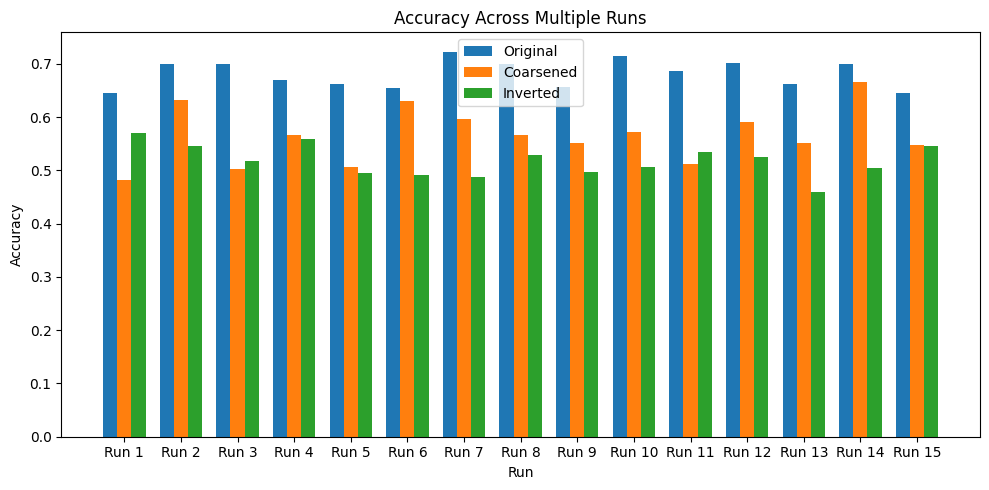

In [7]:

   # num_nearest_init_neighbors_per_type = {"follows": 3, "user": 2}
   # coarsener = HeteroRGCNCoarsener(test.g, 0.4, num_nearest_init_neighbors_per_type)
    
    #coarsener.init()
    #coarsener.coarsen_step()

num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
coarsener = HeteroRGCNCoarsener(original_graph, 0.4, num_nearest_init_neighbors_per_type, device=device, pairs_per_level=10, approx_neigh=False, add_feat= False) 
coarsener.init()

for i in range(1000):
    if not coarsener.summarized_graph.num_nodes()/ original_graph.num_nodes() > 0.1:
        continue
    # if len(coarsener.candidates["paper"]) < 5:
    #     continue
    print(i)
    coarsener.coarsen_step()
    
coarsend_graph = coarsener.summarized_graph
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener.get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 
    
run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=15,
    epochs=150
)


Original Graph Accuracy:   0.6777
Coarsened Graph Accuracy:  0.4970
Inverted Coarsened Accuracy: 0.5437
Original Graph Accuracy:   0.7078
Coarsened Graph Accuracy:  0.5843
Inverted Coarsened Accuracy: 0.5442
Original Graph Accuracy:   0.7319
Coarsened Graph Accuracy:  0.5813
Inverted Coarsened Accuracy: 0.4735
Original Graph Accuracy:   0.6807
Coarsened Graph Accuracy:  0.5452
Inverted Coarsened Accuracy: 0.4956
Original Graph Accuracy:   0.6807
Coarsened Graph Accuracy:  0.5542
Inverted Coarsened Accuracy: 0.5119
Original Graph Accuracy:   0.6657
Coarsened Graph Accuracy:  0.5753
Inverted Coarsened Accuracy: 0.5175
Original Graph Accuracy:   0.7410
Coarsened Graph Accuracy:  0.6235
Inverted Coarsened Accuracy: 0.4842
Original Graph Accuracy:   0.7169
Coarsened Graph Accuracy:  0.6175
Inverted Coarsened Accuracy: 0.5230
Original Graph Accuracy:   0.6928
Coarsened Graph Accuracy:  0.6446
Inverted Coarsened Accuracy: 0.4936
Original Graph Accuracy:   0.7169
Coarsened Graph Accuracy:  0.5

/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/dgl/transforms/functional.py:1367: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


_create_h_spatial_rgcn 0.3922848701477051
_init_costs 0.18690848350524902
_get_union 0.66890549659729


/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroRGCNCoarsener.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long, device=self.device)
/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroRGCNCoarsener.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long, device=self.device)


_h_costs 0.09390878677368164
_create_neighbor_costs 0.007988214492797852
_find_lowest_cost_edges 0.005793571472167969
0


/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroCoarsener.py:295: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:38.)
  indices = torch.searchsorted(sorted_mapping_u[:, 0], src)


_merge_nodes 0.6940107345581055
_h_costs 0.0070230960845947266
_create_neighbor_costs 0.018178939819335938
_find_lowest_cost_edges 0.006494045257568359
1
_merge_nodes 0.42772459983825684
_h_costs 0.00743412971496582
_create_neighbor_costs 0.017952919006347656
_find_lowest_cost_edges 0.006810665130615234
2
_merge_nodes 0.391430139541626
_h_costs 0.0066623687744140625
_create_neighbor_costs 0.017030954360961914
_find_lowest_cost_edges 0.006767988204956055
3
_merge_nodes 0.39411497116088867
_h_costs 0.007607698440551758
_create_neighbor_costs 0.017545223236083984
_find_lowest_cost_edges 0.0066471099853515625
4
_merge_nodes 0.43486976623535156
_h_costs 0.01264500617980957
_create_neighbor_costs 0.10927653312683105
_find_lowest_cost_edges 0.05476546287536621
5
_merge_nodes 0.4710862636566162
_h_costs 0.007093667984008789
_create_neighbor_costs 0.01817178726196289
_find_lowest_cost_edges 0.00648188591003418
6
_merge_nodes 0.426530122756958
_h_costs 0.006959199905395508
_create_neighbor_costs

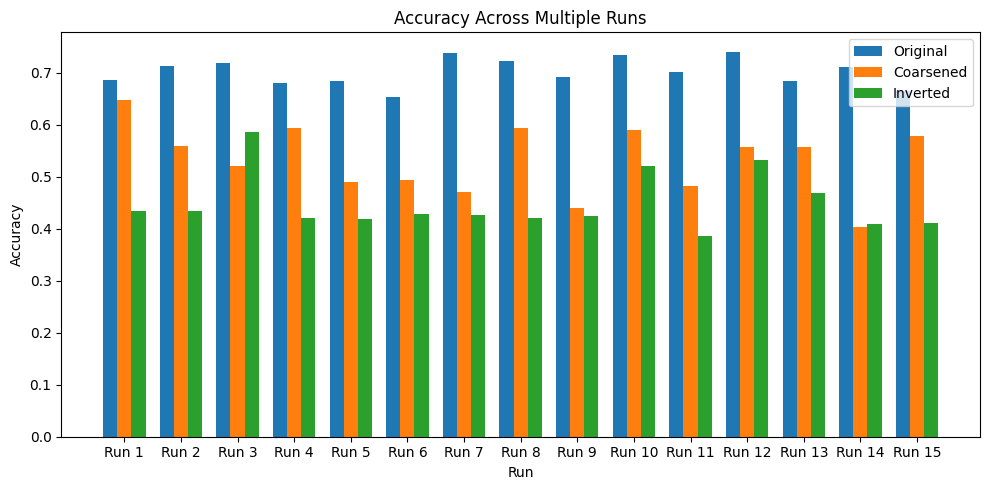

In [6]:

test = TestHomo()
   # num_nearest_init_neighbors_per_type = {"follows": 3, "user": 2}
   # coarsener = HeteroRGCNCoarsener(test.g, 0.4, num_nearest_init_neighbors_per_type)
    
    #coarsener.init()
    #coarsener.coarsen_step()

num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
coarsener = HeteroRGCNCoarsener(original_graph, 0.4, num_nearest_init_neighbors_per_type, device=device, pairs_per_level=10, approx_neigh=True) 
coarsener.init()

for i in range(1000):
    if not coarsener.summarized_graph.num_nodes()/ original_graph.num_nodes() > 0.1:
        continue
    # if len(coarsener.candidates["paper"]) < 5:
    #     continue
    print(i)
    coarsener.coarsen_step()
    
coarsend_graph = coarsener.summarized_graph
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener.get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 
    
run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=15,
    epochs=150
)


0


/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/dgl/transforms/functional.py:1367: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")
/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroRGCNCoarsener.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long, device=self.device)
/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroRGCNCoarsener.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long, device=self.device)


_merge_nodes 0.4289207458496094
_h_costs 0.015902042388916016
_create_neighbor_costs 0.0010764598846435547
_find_lowest_cost_edges 0.21987223625183105
1
_merge_nodes 0.3774285316467285
_h_costs 0.016582012176513672
_create_neighbor_costs 0.003007173538208008
_find_lowest_cost_edges 0.004151821136474609
2
_merge_nodes 0.40769219398498535
_h_costs 0.012159109115600586
_create_neighbor_costs 0.002290487289428711
_find_lowest_cost_edges 0.005664825439453125
3
_merge_nodes 0.32497692108154297
_h_costs 0.014173507690429688
_create_neighbor_costs 0.0011317729949951172
_find_lowest_cost_edges 0.007130146026611328
4
_merge_nodes 0.3559577465057373
_h_costs 0.010802030563354492
_create_neighbor_costs 0.002135038375854492
_find_lowest_cost_edges 0.006598711013793945
5
_merge_nodes 0.3676280975341797
_h_costs 0.010097742080688477
_create_neighbor_costs 0.0011439323425292969
_find_lowest_cost_edges 0.0765986442565918
6
_merge_nodes 0.4271399974822998
_h_costs 0.018574237823486328
_create_neighbor_c

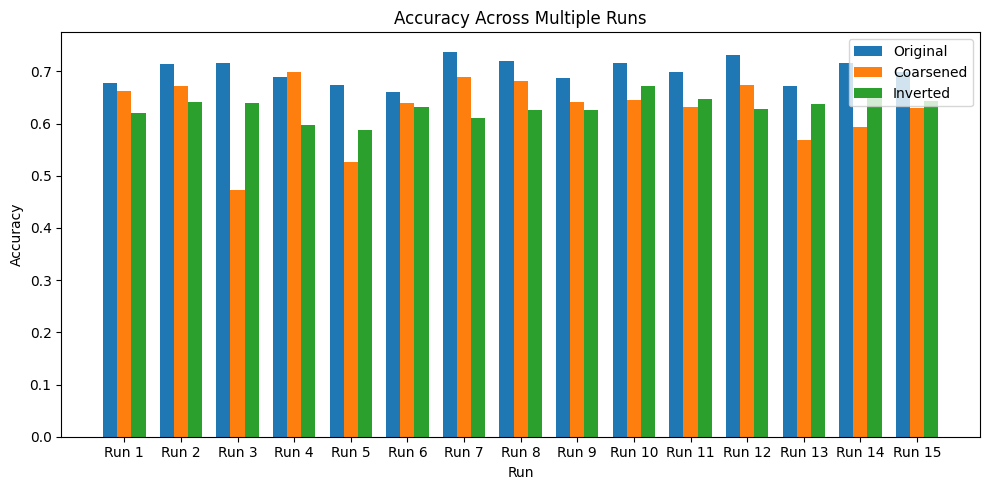

In [9]:

for i in range(2000):
    if not coarsener.summarized_graph.num_nodes()/ original_graph.num_nodes() > 0.1:
        continue
    # if len(coarsener.candidates["paper"]) < 5:
    #     continue
    print(i)
    coarsener.coarsen_step()
    
coarsend_graph = coarsener.summarized_graph
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener.get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 
    
run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=15,
    epochs=150
)

In [ ]:
from collections import Counter
def get_labels( self, mapping, ntype, feat):
    
    labels_dict = dict()
    inverse_mapping = dict()
    for ori_node, coar_node in mapping.items():
        if coar_node in inverse_mapping:
            inverse_mapping[coar_node].append(ori_node)
        else:
            inverse_mapping[coar_node] = [ori_node]
    for coar_node, ori_list in inverse_mapping.items():
        label_list = []
        for ori_node in ori_list:
            label_list.append(self.original_graph.nodes[ntype].data[feat][ori_node].item())
        counter = Counter(label_list)
        
        labels_dict[coar_node],_ = counter.most_common()[0]
    
    return labels_dict

coarsend_graph = coarsener.summarized_graph
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener.get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["labels"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
train_mask = get_labels(coarsener,mapping, "paper", "train_mask")
coarsend_graph.nodes["paper"].data["train_mask"] = torch.tensor([train_mask[i] for i in range(len(train_mask))], device=device)
mask = get_labels(coarsener,mapping, "paper", "train_mask")
coarsend_graph.nodes["paper"].data["test_mask"] = torch.tensor([mask[i] for i in range(len(mask))], device=device)
mask = get_labels(coarsener,mapping, "paper", "train_mask")
coarsend_graph.nodes["paper"].data["val_mask"] = torch.tensor([mask[i] for i in range(len(mask))], device=device)

coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)


print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_out = torch.tensor(self.node_degrees[etype]['out'], device=self.device) + 1.0


torch.Size([3327, 50])
torch.Size([3327, 50])
_create_h_spatial_rgcn 0.00982975959777832
_init_costs 0.004904985427856445
_get_union 1.661513090133667
_costs_of_merges 3.2973294258117676
_init_merge_graph 0.08098554611206055
_find_lowest_cost_edges 0.0017650127410888672
--------- step:  0 ---------
_merge_nodes 0.8313088417053223
longer time -0.015404939651489258
longer time -0.008160591125488281
_update_merge_graph 0.09573793411254883
_find_lowest_cost_edges 0.01605844497680664
--------- step:  1 ---------


/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:955: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long, device=self.device)
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:956: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long, device=self.device)


_merge_nodes 1.6108434200286865
longer time -0.010159969329833984
longer time -0.012884140014648438
_update_merge_graph 0.10350394248962402
_find_lowest_cost_edges 0.010732650756835938
--------- step:  2 ---------
_merge_nodes 2.2772152423858643
longer time -0.007758140563964844
longer time -0.007891654968261719
_update_merge_graph 0.23847150802612305
_find_lowest_cost_edges 0.0161893367767334
--------- step:  3 ---------
_merge_nodes 2.9701426029205322
longer time -0.005855560302734375
longer time -0.015436649322509766
_update_merge_graph 0.2085587978363037
_find_lowest_cost_edges 0.010003089904785156
--------- step:  4 ---------
_merge_nodes 2.782125234603882
longer time -0.009781599044799805
longer time -0.012221813201904297
_update_merge_graph 0.35003042221069336
_find_lowest_cost_edges 0.012754440307617188
--------- step:  5 ---------
_merge_nodes 3.50197172164917
longer time -0.007809162139892578
longer time -0.009402036666870117
_update_merge_graph 0.28955769538879395
_find_lowe

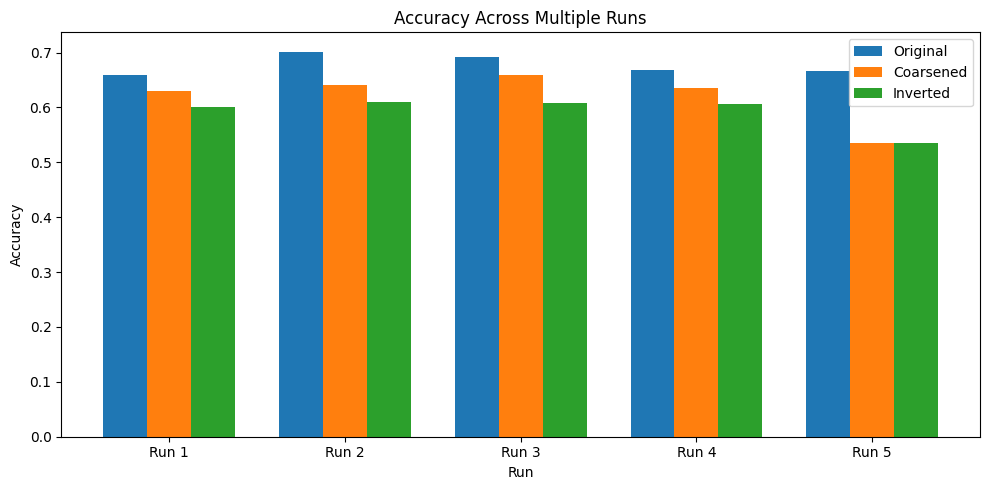

In [8]:
coarsener =  HeteroCoarsener(None,original_graph, 0.1, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=10, is_neighboring_h=True, is_adj=True) #, device="cpu" 
torch.cuda.empty_cache()
#coarsener = HeteroCoarsener(None,original_graph, 0.1, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=10, is_neighboring_h= False) #
coarsener.init_step()
isNewMerges = True
for i in range(1000):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()

coarsend_graph = coarsener.get_coarsend_graph()
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=5,
    epochs=150
)

    

/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_out = torch.tensor(self.node_degrees[etype]['out'], device=self.device) + 1.0
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_in  = torch.tensor(self.node_degrees[etype]['in'], device=self.device)  + 1.0


_create_h_spatial_rgcn 0.006117582321166992
_init_costs 0.5184230804443359
_get_union 1.786280632019043
_costs_of_merges 4.9096620082855225
_init_merge_graph 0.11651420593261719
_find_lowest_cost_edges 0.00853419303894043
--------- step:  0 ---------
_merge_nodes 0.018207788467407227


/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:861: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long, device=self.device)
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:862: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long, device=self.device)


_update_merge_graph 0.07761597633361816
_find_lowest_cost_edges 0.00998234748840332
--------- step:  1 ---------
_merge_nodes 0.02245187759399414
_update_merge_graph 0.07283496856689453
_find_lowest_cost_edges 0.010074138641357422
--------- step:  2 ---------
_merge_nodes 0.04828071594238281
_update_merge_graph 0.07335495948791504
_find_lowest_cost_edges 0.009045600891113281
--------- step:  3 ---------
_merge_nodes 0.018459796905517578
_update_merge_graph 0.07345247268676758
_find_lowest_cost_edges 0.010666847229003906
--------- step:  4 ---------
_merge_nodes 0.023074865341186523
_update_merge_graph 0.07170987129211426
_find_lowest_cost_edges 0.010381221771240234
--------- step:  5 ---------
_merge_nodes 0.014411687850952148
_update_merge_graph 0.0589902400970459
_find_lowest_cost_edges 0.011609792709350586
--------- step:  6 ---------
_merge_nodes 0.011324644088745117
_update_merge_graph 0.06532883644104004
_find_lowest_cost_edges 0.006737470626831055
--------- step:  7 ---------
_m

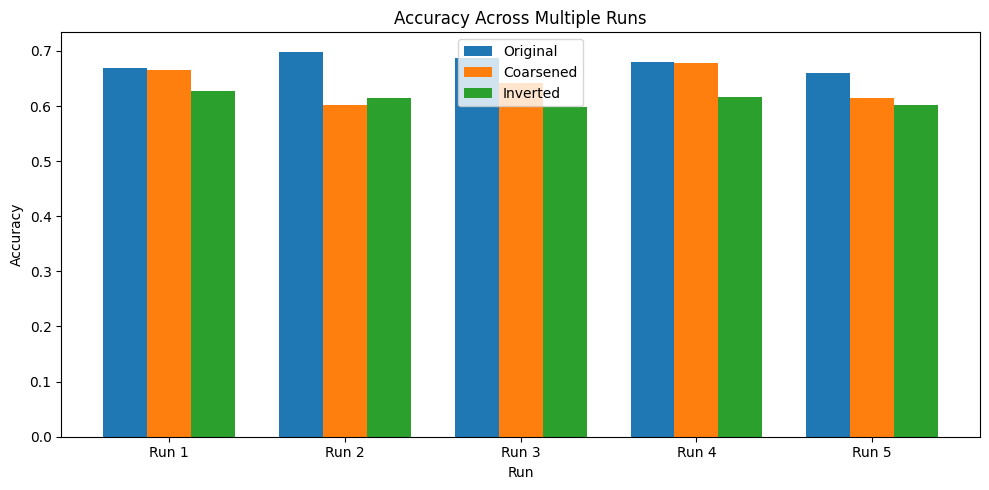

In [8]:

coarsener = HeteroCoarsener(None,original_graph, 0.1, num_nearest_per_etype=100, num_nearest_neighbors=100,pairs_per_level=10) #
coarsener.init_step()
isNewMerges = True
for i in range(1000):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()

coarsend_graph = coarsener.get_coarsend_graph()
coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))])
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=5,
    epochs=150
)

    

/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_out = torch.tensor(self.node_degrees[etype]['out'], device=self.device) + 1.0
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_in  = torch.tensor(self.node_degrees[etype]['in'], device=self.device)  + 1.0


_create_h_spatial_rgcn 0.0037908554077148438
_init_costs 0.5111360549926758
_get_union 0.8965177536010742
_costs_of_merges 1.528153657913208
_init_merge_graph 0.0017833709716796875
_find_lowest_cost_edges 0.0011873245239257812
--------- step:  0 ---------
_merge_nodes 0.007738351821899414
_update_merge_graph 0.13765764236450195
_find_lowest_cost_edges 0.003663778305053711
--------- step:  1 ---------
_merge_nodes 0.009668111801147461


/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:609: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long)
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:610: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long)


_update_merge_graph 0.025066614151000977
_find_lowest_cost_edges 0.002809762954711914
--------- step:  2 ---------
_merge_nodes 0.010076522827148438
_update_merge_graph 0.02284073829650879
_find_lowest_cost_edges 0.0033648014068603516
--------- step:  3 ---------
_merge_nodes 0.007615566253662109
_update_merge_graph 0.021021604537963867
_find_lowest_cost_edges 0.0035233497619628906
--------- step:  4 ---------
_merge_nodes 0.006868124008178711
_update_merge_graph 0.021582365036010742
_find_lowest_cost_edges 0.0033566951751708984
--------- step:  5 ---------
_merge_nodes 0.007633209228515625
_update_merge_graph 0.02542257308959961
_find_lowest_cost_edges 0.002025604248046875
--------- step:  6 ---------
_merge_nodes 0.008369922637939453
_update_merge_graph 0.024696826934814453
_find_lowest_cost_edges 0.0024309158325195312
--------- step:  7 ---------
_merge_nodes 0.011283397674560547
_update_merge_graph 0.022429704666137695
_find_lowest_cost_edges 0.0033512115478515625
--------- step:  

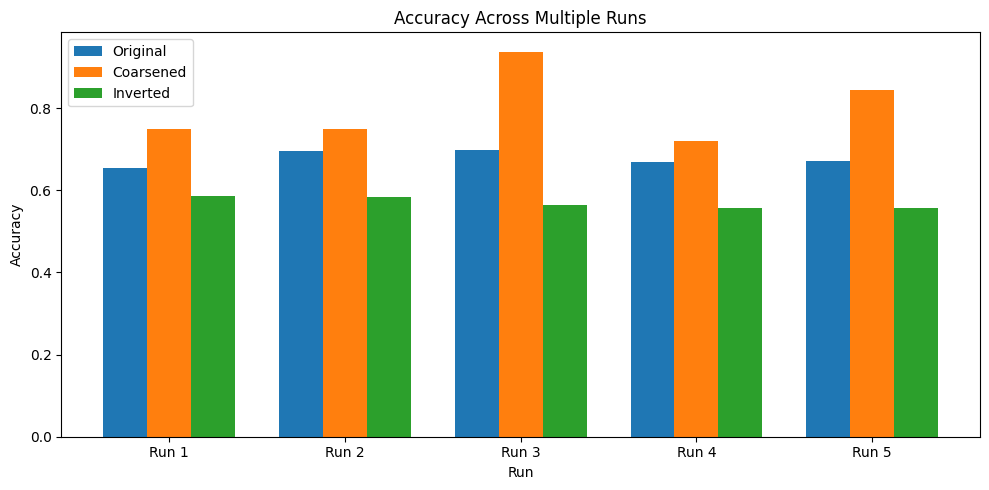

In [7]:
R = {
    "paper": 0,
    "cited-by":0,
    "cites":1,

    
}
coarsener = HeteroCoarsener(None,original_graph, 0.1, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=10, is_neighboring_h= False, R=R) #
coarsener.init_step()
isNewMerges = True
for i in range(1000):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()

coarsend_graph = coarsener.get_coarsend_graph()
coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))])
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

run_multiple_experiments(
    original_graph=original_graph,
    coarsend_graph=coarsend_graph,
    mapping=mapping,
    get_splits_and_labels=get_splits_and_labels,
    model_class=HeteroGCNCiteer,  # or ImprovedHeteroGNN if needed
    num_runs=5,
    epochs=150
)

    

In [29]:
coarsend_graph

Graph(num_nodes={'paper': 33},
      num_edges={('paper', 'cited-by', 'paper'): 640, ('paper', 'cites', 'paper'): 640},
      metagraph=[('paper', 'paper', 'cited-by'), ('paper', 'paper', 'cites')])

Epoch 1:
  Original Graph - Loss: 1.7954, Accuracy: 0.2530
  Coarsened Graph - Loss: 1.7924, Accuracy: 0.3333
  Inverted Coarsened - Accuracy: 0.2247

Epoch 11:
  Original Graph - Loss: 1.6874, Accuracy: 0.5422
  Coarsened Graph - Loss: 1.1606, Accuracy: 0.3333
  Inverted Coarsened - Accuracy: 0.2178

Epoch 21:
  Original Graph - Loss: 1.5403, Accuracy: 0.6024
  Coarsened Graph - Loss: 1.0897, Accuracy: 0.3333
  Inverted Coarsened - Accuracy: 0.2178

Epoch 31:
  Original Graph - Loss: 1.3229, Accuracy: 0.6386
  Coarsened Graph - Loss: 1.0766, Accuracy: 0.3333
  Inverted Coarsened - Accuracy: 0.2178

Epoch 41:
  Original Graph - Loss: 1.0821, Accuracy: 0.6687
  Coarsened Graph - Loss: 1.0654, Accuracy: 0.3333
  Inverted Coarsened - Accuracy: 0.2178

Epoch 51:
  Original Graph - Loss: 0.8761, Accuracy: 0.6898
  Coarsened Graph - Loss: 1.0536, Accuracy: 0.3333
  Inverted Coarsened - Accuracy: 0.2178

Epoch 61:
  Original Graph - Loss: 0.7283, Accuracy: 0.7048
  Coarsened Graph - Loss: 1.0

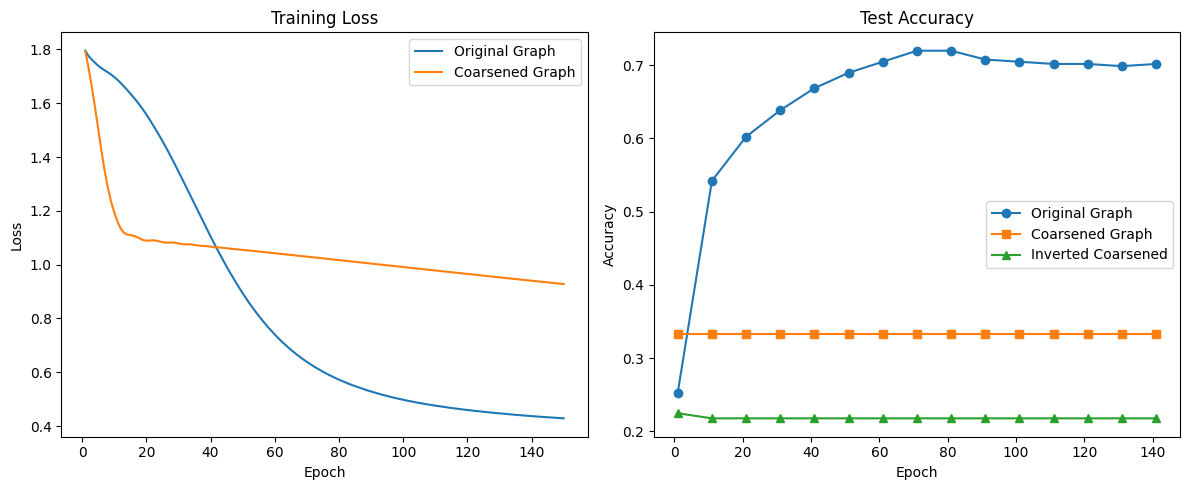

Final Performance Comparison:
Original Graph Accuracy: 0.7018
Coarsened Graph Accuracy: 0.3333
Inverted Coarsened Accuracy: 0.2178


In [28]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_original = HeteroGCN(in_dim=original_graph.nodes["paper"].data["feat"].shape[1], hidden_dim=64,
                  out_dim=6, rel_names=original_graph.etypes)


feat_orig = {'paper': original_graph.nodes['paper'].data['feat']}

# Use our splits utility
data_splits_orig = get_splits_and_labels(original_graph)
train_idx_orig = data_splits_orig['train_idx']
val_idx_orig = data_splits_orig['val_idx']
test_idx_orig = data_splits_orig['test_idx']
labels_orig = original_graph.nodes['paper'].data['label']

optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)



model_coarsened = HeteroGCN(in_dim=coarsend_graph.nodes["paper"].data["feat"].shape[1], hidden_dim=64,
                  out_dim=6, rel_names=original_graph.etypes)


feat_coar = {'paper': coarsend_graph.nodes['paper'].data['feat']}

# Use our splits utility
data_splits_coar = get_splits_and_labels(coarsend_graph)
train_idx_coar = data_splits_coar['train_idx']
val_idx_coar = data_splits_coar['val_idx']
test_idx_coar = data_splits_coar['test_idx']
labels_coar = coarsend_graph.nodes['paper'].data['label']

optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)





target_node_type = "paper"



# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in inversion_map.items():
        if not coarsened_node in test_mask:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
    
                
        if correct:
            correct_count += 1
     #   else:
      #      print(f"Mismatch: Coarsened Node {coarsened_node} predicted {coarse_pred}, Original Node {orig_node} label {orig_label}")
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    #print(original_x_original_data.edge_index_dict)
    logits = model_original(original_graph, feat_orig)['paper']
    loss = F.cross_entropy(logits[train_idx_orig], labels_orig[train_idx_orig])
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    logits = model_coarsened(coarsend_graph, feat_coar)["paper"]
    loss = F.cross_entropy(logits[train_idx_coar], labels_coar[train_idx_coar])
    
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

    
# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        logits = model_original(original_graph, feat_orig)
        pred = logits[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = (pred[val_idx_orig] == labels_orig[val_idx_orig]).sum().item()
        return correct / val_idx_orig.shape[0]

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        logits = model_original(coarsend_graph, feat_coar)
        pred = logits[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = (pred[val_idx_coar] == labels_coar[val_idx_coar]).sum().item()
        coarsened_acc =  correct / val_idx_coar.shape[0]
        inverted_acc = 0
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
              pred,  
              mapping,
              original_graph.nodes[target_node_type].data["label"], 
              test_idx_coar
          )
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}
epochs = 150
for epoch in range(epochs):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, epochs, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import numpy as np
import random

# fix global seeds (we'll override per‐run below)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class GCN(torch.nn.Module):
    def __init__(self, in_feats, hidden_dim, out_feats, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_feats)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def run(seed):
    # reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # 1) Load Citeseer public split
    dataset = Planetoid(root='data/Citeseer', name='CiteSeer', split='public')
    data = dataset[0].to(device)

    # 2) Model & optimizer (Table 6 hyperparams)
    model = GCN(
        in_feats   = dataset.num_features,
        hidden_dim = 256,
        out_feats  = dataset.num_classes,
        dropout    = 0.5
    ).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-2,
        weight_decay=5e-4
    )

    best_val_acc = 0.0
    test_acc_at_best = 0.0

    # 3) Training with early stopping by validation
    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        logits = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)

        train_acc = (preds[data.train_mask] == data.y[data.train_mask]).float().mean()
        val_acc   = (preds[data.val_mask]   == data.y[data.val_mask]).float().mean()
        test_acc  = (preds[data.test_mask]  == data.y[data.test_mask]).float().mean()

        # track best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc_at_best = test_acc

    return test_acc_at_best.item()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    seeds = [1, 2, 3, 4, 5]
    results = [run(s) for s in seeds]
    mean = np.mean(results)
    std  = np.std(results)
    print(f'Test accuracy over seeds {seeds}:')
    print([f'{r*100:.2f}%' for r in results])
    print(f'Mean ± std: {mean*100:.2f}% ± {std*100:.2f}%')


Test accuracy over seeds [1, 2, 3, 4, 5]:
['68.40%', '69.80%', '70.30%', '68.90%', '68.30%']
Mean ± std: 69.14% ± 0.79%
